**Loan Approval Prediction**

1. Essential Imports and Global Settings

In [1]:
# ## 1. Essential Imports and Global Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Setup
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

2. Configuration and Dataset Path

In [2]:
# ## 2. Configuration and Dataset Path
DATA_PATH = "../data/loan_data.csv"
SEED = 42

3. Load and Inspect the Dataset

In [3]:
# ## 3. Load and Inspect Data
df = pd.read_csv(DATA_PATH)

print("Dataset loaded.\n")
display(df.head())
display(df.info())
print("\nShape:", df.shape)
print("\nTarget balance:\n", df['LoanApproved'].value_counts())


Dataset loaded.



,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,1,39.2
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,1,41.6
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtilizationRate   200

None


Shape: (20000, 36)

Target balance:
 LoanApproved
0    11264
1     8736
Name: count, dtype: int64


4. Numeric Distributions

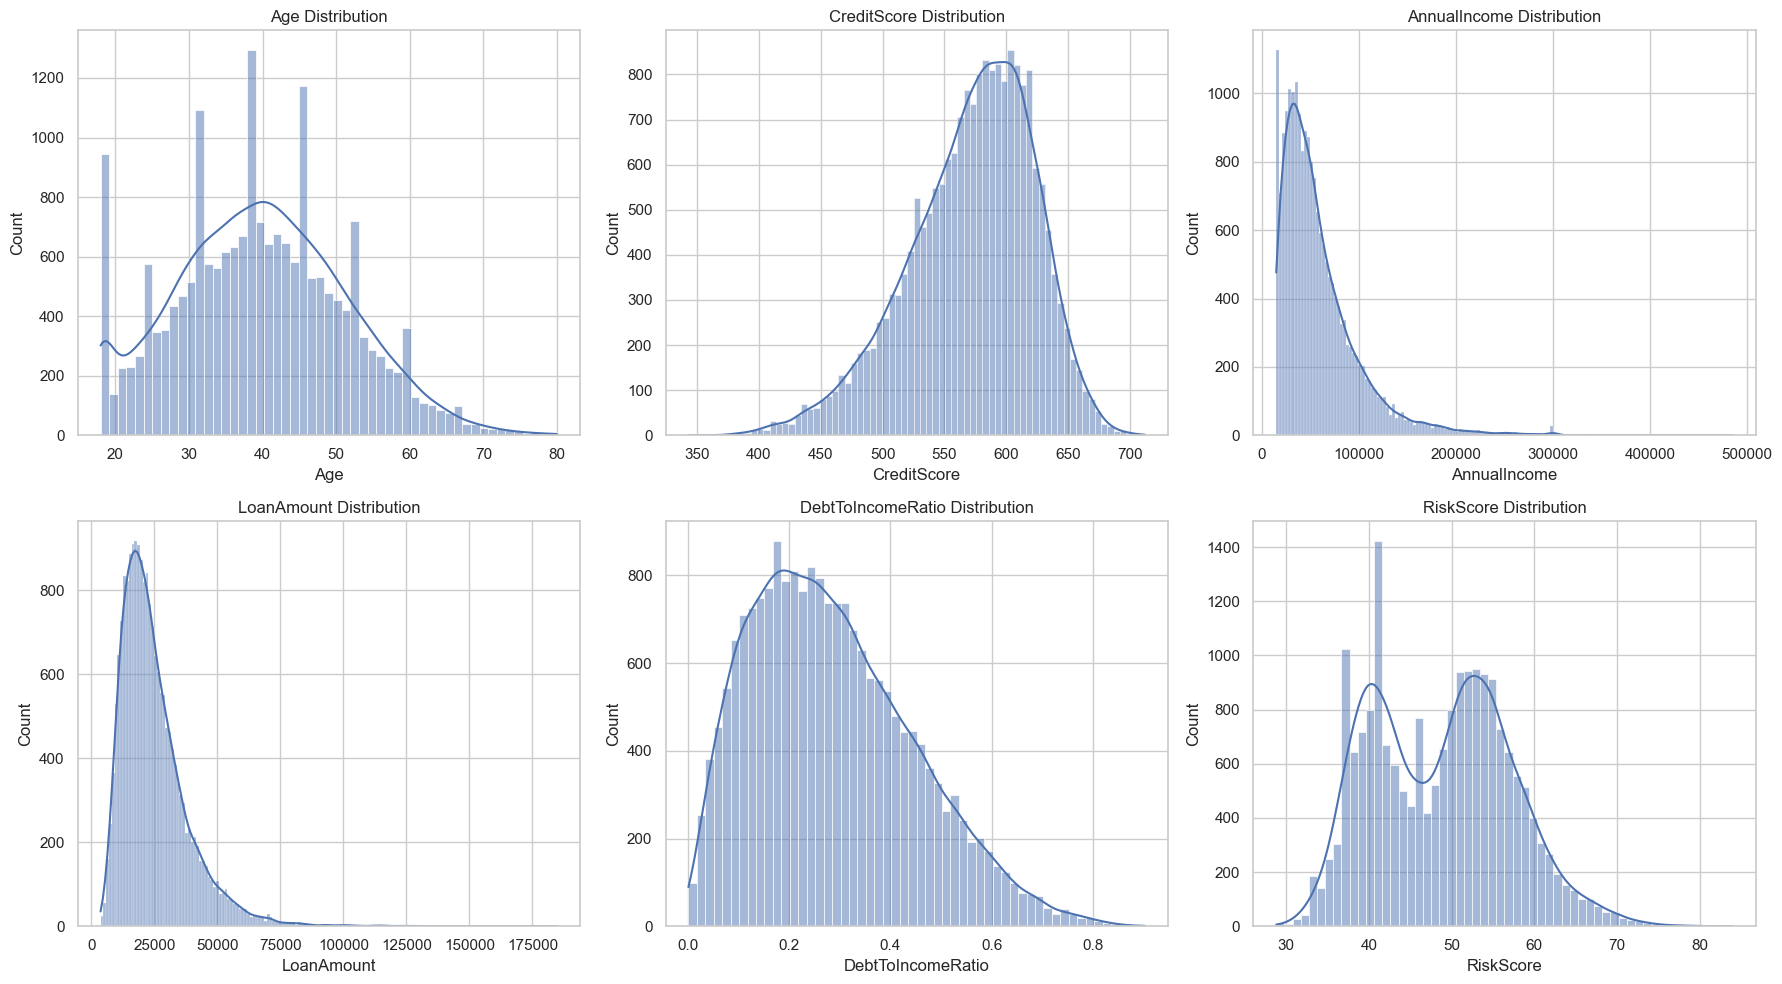

In [4]:
# ## 4. Key Feature Distributions
num_cols = ['Age', 'CreditScore', 'AnnualIncome', 
            'LoanAmount', 'DebtToIncomeRatio', 'RiskScore']
plt.figure(figsize=(18,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

5. Visualize Class Distribution

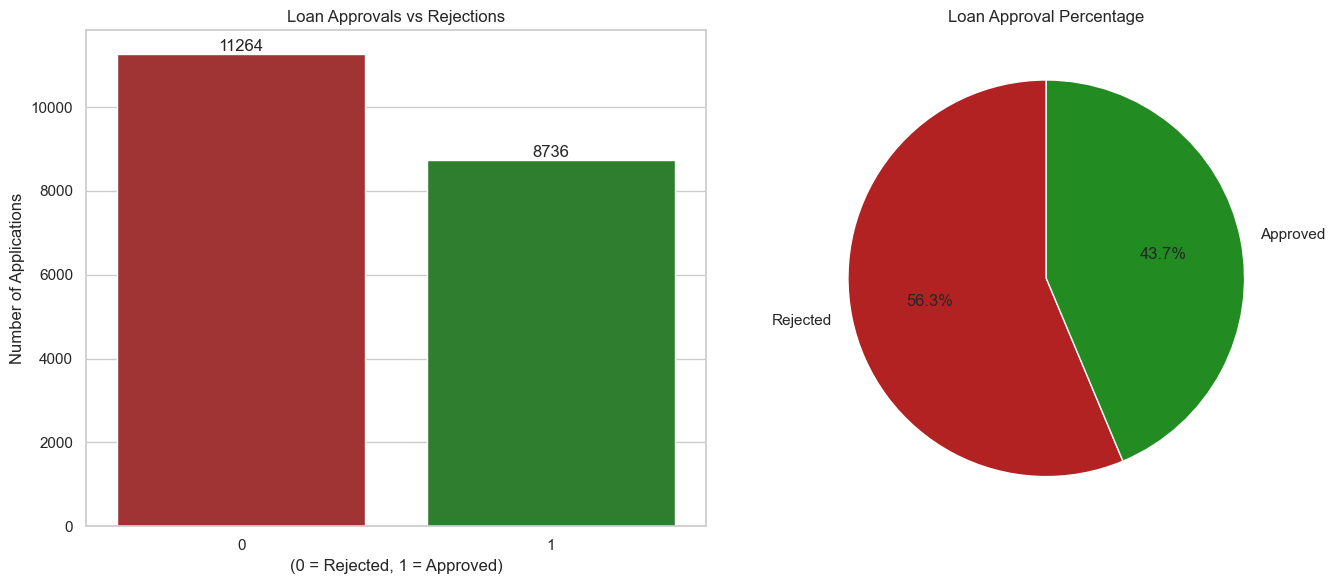

In [5]:
# ## 5. Loan Approval Distribution: Count Bar + Pie Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color mapping
colors = ['firebrick', 'forestgreen']  # [Rejected, Approved]

# ----- Bar Chart -----
ax1 = axes[0]
sns.countplot(
    x='LoanApproved',
    data=df,
    palette=colors,
    ax=ax1
)
ax1.set_title('Loan Approvals vs Rejections')
ax1.set_xlabel('(0 = Rejected, 1 = Approved)')
ax1.set_ylabel('Number of Applications')

# Add count labels
for p in ax1.patches:
    ax1.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom'
    )

# ----- Pie Chart -----
ax2 = axes[1]
counts = df['LoanApproved'].value_counts().sort_index()
labels = ['Rejected', 'Approved']

ax2.pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
ax2.set_title('Loan Approval Percentage')

plt.tight_layout()
plt.show()

6. Data Cleaning & Encoding

In [6]:
# ## 6. Data Cleaning & Encoding

# Drop rows with any missing values
df.dropna(inplace=True)

# Drop date/time columns
df.drop(columns=['ApplicationDate'], inplace=True)

# Ensure no missing values remain
assert df.isnull().sum().sum() == 0, "There are still missing values in the dataset!"

# Identify categorical columns (object/string types)
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Separate low-cardinality and high-cardinality categoricals
#    - Low-card: 10 or fewer unique values -> safe for one-hot encoding
#    - High-card: more than 10 -> drop to avoid dimensional explosion
low_card = [col for col in cat_cols if df[col].nunique() <= 10]
high_card = [col for col in cat_cols if col not in low_card]

# Drop high-cardinality categorical columns
df.drop(columns=high_card, inplace=True)

# One-hot encode low-cardinality categorical columns
#    - drop_first=True avoids multicollinearity (dummy variable trap)
df = pd.get_dummies(df, columns=low_card, drop_first=True)

# Final shape check after encoding
print("Preprocessing done. Post-encode shape:", df.shape)

Preprocessing done. Post-encode shape: (20000, 46)


7. Train-Test Split & Class Balance

Train/test split completed.
Train set: (16000, 45), Test set: (4000, 45)



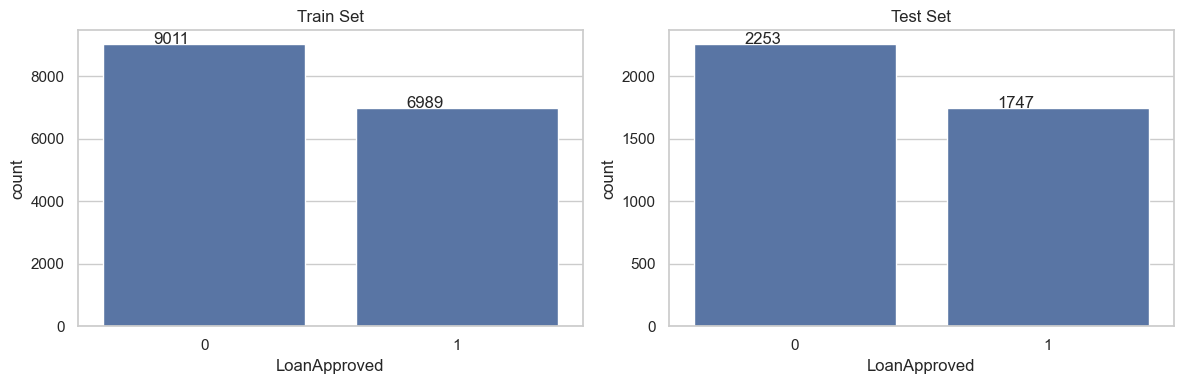

In [7]:
# ## 7. Train-Test Split & Balance

# Separate features and target variable
X = df.drop(columns='LoanApproved')     # Features (all columns except target)
y = df['LoanApproved']                  # Target (binary: 0 = rejected, 1 = approved)

# Split into training and testing sets
# - test_size=0.2 -> 80% training, 20% testing
# - stratify=y -> maintain target class distribution
# - random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Check that no object (non-numeric) columns remain in training features
# This ensures model compatibility (especially for scikit-learn estimators)
assert X_train.select_dtypes(include='object').empty, "Non-numeric columns found!"

# Print the shape of the resulting splits
print("Train/test split completed.")
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}\n")

# Visualize class distribution before training (important for balance check)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot class distribution for training set
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title('Train Set')

# Plot class distribution for test set
sns.countplot(x=y_test, ax=axs[1])
axs[1].set_title('Test Set')

# Add count annotations to each bar
for ax in axs:
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x() + 0.2, p.get_height()))

plt.tight_layout()
plt.show()